# 🏷️ Step 5 : Mini-Taxonomy of Definitions

**Goal**: Extract and classify definitions of "Agentic AI" in the corpus

**Hybrid approach**:
1. **Semi-automatic extraction** - Identify definition paragraphs
2. **Manual classification** - Group into conceptual categories
3. **Visualization** - Tables and diagrams (treemap, sunburst)

**Expected categories**:
- AI as Copilots/Assistants
- AI as Autonomous Workers
- AI as Multi-Agent Ecosystems/Orchestrators
- AI as Governance/Risk Challenges

**Output**: Taxonomy of definitions + report visualizations

## 🔧 Setup Config & Imports

In [38]:
import warnings
warnings.filterwarnings('ignore')

# Imports
import json
import re
from pathlib import Path
from collections import Counter, defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# NLP
import nltk
from nltk.tokenize import sent_tokenize

# Viz
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
%matplotlib inline

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10

print("✅ Imports")

✅ Imports


## 📂 Load processed corpus

In [39]:
# Paths
PROJECT_ROOT = Path.cwd().parent
PROCESSED_DATA = PROJECT_ROOT / "data" / "processed"
TEXTS_DIR = PROCESSED_DATA / "texts"
METADATA_FILE = PROCESSED_DATA / "metadata" / "corpus_metadata.json"

# Create taxonomy folder
TAXONOMY_DIR = PROCESSED_DATA / "taxonomy"
TAXONOMY_DIR.mkdir(exist_ok=True)

print(f"📁 Taxonomy folder : {TAXONOMY_DIR}")

📁 Taxonomy folder : c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\taxonomy


In [40]:
# Load raw texts
texts = {}
with open(METADATA_FILE, 'r', encoding='utf-8') as f:
    metadata = json.load(f)

for doc_id in metadata.keys():
    text_file = TEXTS_DIR / f"{doc_id}.txt"
    if text_file.exists():
        with open(text_file, 'r', encoding='utf-8') as f:
            texts[doc_id] = f.read()

print(f"✅ {len(texts)} documents loaded")

✅ 20 documents loaded


In [41]:
# Mapping doc_id -> source_type
doc_to_source = {doc_id: metadata[doc_id]['source_type'] 
                 for doc_id in texts.keys()}

## 📝 Quick text cleaning

In [42]:
# Custom stopwords
CUSTOM_STOPWORDS = {
    # Consulting jargon
    'executive', 'summary', 'introduction', 'conclusion', 'chapter', 'section',
    'figure', 'table', 'appendix', 'page', 'report', 'study', 'analysis',
    
    # Abréviations courantes
    'et', 'al', 'inc', 'ltd', 'corp', 'eg', 'ie', 'etc',
    
    # Années (si non pertinentes)
    # '2023', '2024', '2025'  # Décommenter si tu veux les enlever

    # Addings
    'cid', 'new', 'datum', 'across', 'many', 'must', 'year', 'like', 'non',
    'aaron', 'end', 'east', 'london', 'school', 'deputy', 'minister', 'party',

    # People / random stuff
    'atsushi', 'kanehira', 'david', 'crawford', 'anne', 'hoecker', 'lari', 'inen', 'wang',
    'fuet', 'ufureture', 'hector', 'rivoire', 'valentino', 'valentini', 'eth', 'gth', 'kazuhiro', 'sasabuchi',
    'sshhaappinign', 'gth', 'movillo', 'matta', 'naoki', 'wake', 'usman', 'ikhlaq',
    'josefina', 'movillo', 'almudena', 'benjamin', 'chino', 'mart', 'castro', 'michelle', 'gill',
    'syed', 'ali', 'laurent', 'pierre', 'baculard', 'bharat', 'bansal', 'ann', 'bosche', 'peter', 'bowen', 'steven', 'breeden', 
    'alessandro', 'cannarsi', 'willy', 'chang', 'matthew', 'crupi', 'arjun', 'dutt', 'greg', 'fiore', 'jonathan',
    'frick', 'pascal', 'gautheron', 'adam', 'haller', 'hanbury', 'karen', 'harris', 'jonny', 'holiday', 'mark', 'kovac', 
    'tamara', 'lewis', 'lipman', 'neil', 'malik', 'justin', 'murphy', 'christopher', 'perry', 'bill', 'radzevych', 'paul',
    'dana', 'aulanier', 'chris', 'bell', 'purna', 'doddapaneni', 'stephen', 'gabe', 'dunn', 'aaron', 'ryan', 'petranovich', 'tanvee', 'rao',
    'renno', 'michael', 'schallehn', 'jennifer', 'smith', 'ravi', 'vijayaraghavan', 'jue', 'chuck', 'whitten',
    
    # Sources
    'bain', 'bcg', 'mckinsey', 'pwc', 'deloitte', 'mit', 'stanford', 'harvard', 'google',
    'microsoft', 'openai', 'wef', 'oecd', 'undp', 'iti', 'boston', 'sloan', 'arxiv'
}

print(f"🚫 {len(CUSTOM_STOPWORDS)} custom stopwords")
print(f"\nExamples: {list(CUSTOM_STOPWORDS)[:10]}")

🚫 161 custom stopwords

Examples: ['mckinsey', 'east', 'jonny', 'ali', 'minister', 'jennifer', 'paul', 'chuck', 'boston', 'mit']


In [ ]:
def clean_text(text):
    """
    Clean the text in depth.
    
    Steps:
    1. Convert to lowercase
    2. Remove URLs and emails
    3. Remove numbers
    4. Remove excessive punctuation
    5. Normalize spaces
    """
    # Lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)
    
    # Remove emails
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove numbers (but keep words with numbers like "ai4business")
    text = re.sub(r'\b\d+\b', '', text)
    
    # Remove special characters and punctuation (keep hyphens and apostrophes)
    # text = re.sub(r'[^\w\s\'-]', ' ', text)
    
    # Normalize multiple spaces
    text = re.sub(r'\s+', ' ', text)

    # Brut force cleaning
    text = re.sub(r"[^a-z\s]", " ", text)

    for word in CUSTOM_STOPWORDS:
        text = re.sub(r"word", "", text)
    
    # Remove leading and trailing spaces
    text = text.strip()
    
    return text

## 🔍 Semi-automatic extraction of definition

### Extraction strategy

Here, we will extract the definitions of agentic AI, autonomous agents, and AI agents from the text. To do so, we will identify the phrases/paragraphs which:
1. Contain the key terms: "agentic ai", "ai agent", "autonomous agent"
2. Use definition markers: "is", "are", "defined as", "refers to", "means"
3. Are in the first sections (introduction, definitions)

In [5]:
def extract_definition_candidates(text, doc_id):
    """
    Extract candidate phrases as definitions.
    
    Criterias:
    - Contains key terms (agentic, agent, autonomous)
    - Contains definitional markers
    - Reasonable length (30-300 words)
    """
    # Tokenize in phrases
    sentences = sent_tokenize(text)
    
    # Key terms to search
    key_terms = [
        r'\bagentic\s+ai\b',
        r'\bai\s+agent[s]?\b',
        r'\bautonomous\s+agent[s]?\b',
        r'\bagentic\s+system[s]?\b',
        r'\bagent[s]?\s+are\b',
        r'\bagent[s]?\s+is\b'
    ]
    
    # Definitional markers
    def_markers = [
        r'\bis\s+defined\s+as\b',
        r'\bare\s+defined\s+as\b',
        r'\brefers?\s+to\b',
        r'\bmeans?\b',
        r'\bcan\s+be\s+understood\s+as\b',
        r'\bcharacterized\s+by\b',
        r'\bconsists?\s+of\b',
        r'\benables?\b',
        r'\bcapable\s+of\b'
    ]
    
    candidates = []
    
    for i, sentence in enumerate(sentences):
        sentence_lower = sentence.lower()
        
        # Check key terms presence
        has_key_term = any(re.search(pattern, sentence_lower) for pattern in key_terms)
        
        if not has_key_term:
            continue
        
        # Check definitional markers presence
        has_def_marker = any(re.search(pattern, sentence_lower) for pattern in def_markers)
        
        # Check length
        word_count = len(sentence.split())
        
        # Score phrase
        score = 0
        if has_key_term:
            score += 2
        if has_def_marker:
            score += 3
        if 30 <= word_count <= 300:
            score += 1
        if i < len(sentences) * 0.3:  # In first 30%
            score += 1
        
        if score >= 3:
            # Extract next phrase for context
            context = sentence
            if i + 1 < len(sentences):
                context += " " + sentences[i + 1]
            
            candidates.append({
                'doc_id': doc_id,
                'sentence_id': i,
                'text': sentence.strip(),
                'context': context.strip(),
                'word_count': word_count,
                'score': score,
                'has_def_marker': has_def_marker
            })
    
    return candidates

In [6]:
# Extract candidates for docs
all_candidates = []

for doc_id, text in texts.items():
    candidates = extract_definition_candidates(text, doc_id)
    all_candidates.extend(candidates)
    
    filename = metadata[doc_id]['filename']
    print(f"\n📄 {filename}")
    print(f"   {len(candidates)} potential definitions found")

print(f"\n✅ Total: {len(all_candidates)} candidate definitions extracted")


📄 Bain_report_technology_report_2025.pdf
   1 potential definitions found

📄 BCG_AI_Agents_2025.pdf
   1 potential definitions found

📄 Deloitte_The_business_imperative_for_Agentic_AI_2025.pdf
   1 potential definitions found

📄 Google_Agentic_AI_TAM_Analysis_2025.pdf
   1 potential definitions found

📄 Google_The_ROI_of_AI_2025.pdf
   1 potential definitions found

📄 Harvard_Designing_a_Successful_Agentic_AI_System_2025.pdf
   1 potential definitions found

📄 ITI_Understanding_Agentic_AI_Policy_Guide_2025.pdf
   1 potential definitions found

📄 McKinsey_Empowering_advanced_industries_with_agentic_AI_2025.pdf
   1 potential definitions found

📄 McKinsey_The_agentic_organization_contours_of_the_next_paradigm_for_the_AI_era_2025.pdf
   1 potential definitions found

📄 McKinsey_What_is_an_AI_Agent_2025.pdf
   1 potential definitions found

📄 Microsoft_Agent_AI_Towards_a_Holistic_Intelligence_2025.pdf
   1 potential definitions found

📄 MIT_Reimagining_the_future_of_banking_with_agentic_A

### Extracted definitions overview

In [7]:
# Create DataFrame
df_candidates = pd.DataFrame(all_candidates)

# Add metadata
df_candidates['filename'] = df_candidates['doc_id'].map(
    lambda x: metadata[x]['filename']
)
df_candidates['source_type'] = df_candidates['doc_id'].map(doc_to_source)

# Desc score order
df_candidates = df_candidates.sort_values('score', ascending=False)

print("TOP 10 CANDIDATE DEFINITIONS (by score)")
for i, row in df_candidates.head(10).iterrows():
    print(f"\n{row['filename']} (Score: {row['score']})")
    print(f"  {row['text'][:200]}...")

TOP 10 CANDIDATE DEFINITIONS (by score)

Bain_report_technology_report_2025.pdf (Score: 6)
  technology report ai leaders are extending their edge authors and acknowledgments david crawford chairman of bain company s global technology media and telecommunications practice anne hoecker global ...

Microsoft_Agent_AI_Towards_a_Holistic_Intelligence_2025.pdf (Score: 6)
  agent ai towards a holistic intelligence qiuyuanhuang naokiwake   bidiptasarkar zanedurante rangong rohantaori yusukenoda demetriterzopoulos noborukuno adefamoti ashleyllorens johnlangford  hoivo life...

Standford_Policy_brief_Simulating_human_behavior_with_AI_Agents_2025.pdf (Score: 6)
  policy brief hai policy society may simulating human key takeaways simulating human attitudes and behavior with ai behaviors could enable researchers to test interventions and theories and gain real w...

PwC_Agentic_AI_the_new_frontier_in_GenAI_2024.pdf (Score: 6)
  agentic ai the new frontier in genai an executive playbook harnessing 

## 📝 Manual classification of definitions

**IMPORTANT**: This section requires manual revision.

For each candidate definition, you must:
1. Read the complete text
2. Assign a category
3. Optionally merge or delete certain entries

In [8]:
# Define taxonomy categories
TAXONOMY_CATEGORIES = {
    'copilot': {
        'label': 'AI as Copilots/Assistants',
        'description': 'AI agents that augment human work, provide suggestions, collaborate with users',
        'keywords': ['copilot', 'assistant', 'augment', 'support', 'collaborate', 'suggest', 'help']
    },
    'autonomous_worker': {
        'label': 'AI as Autonomous Workers',
        'description': 'AI agents that independently execute tasks with minimal human intervention',
        'keywords': ['autonomous', 'independent', 'execute', 'automate', 'replace', 'perform']
    },
    'orchestrator': {
        'label': 'AI as Multi-Agent Ecosystems/Orchestrators',
        'description': 'AI systems coordinating multiple agents, workflows, or complex processes',
        'keywords': ['orchestrate', 'coordinate', 'multi-agent', 'ecosystem', 'workflow', 'multi-step', 'planning']
    },
    'governance': {
        'label': 'AI as Governance/Risk Challenges',
        'description': 'AI agents framed through ethical, regulatory, or risk management lens',
        'keywords': ['governance', 'risk', 'compliance', 'regulation', 'ethics', 'safety', 'alignment', 'control']
    },
    'other': {
        'label': 'Other/Uncategorized',
        'description': 'Definitions that don\'t fit main categories',
        'keywords': []
    }
}

print("\n📋 Taxonomy categories:")
for cat_id, cat_info in TAXONOMY_CATEGORIES.items():
    print(f"\n  {cat_info['label']}")
    print(f"    {cat_info['description']}")
    print(f"    Key words: {', '.join(cat_info['keywords'][:5])}")


📋 Taxonomy categories:

  AI as Copilots/Assistants
    AI agents that augment human work, provide suggestions, collaborate with users
    Key words: copilot, assistant, augment, support, collaborate

  AI as Autonomous Workers
    AI agents that independently execute tasks with minimal human intervention
    Key words: autonomous, independent, execute, automate, replace

  AI as Multi-Agent Ecosystems/Orchestrators
    AI systems coordinating multiple agents, workflows, or complex processes
    Key words: orchestrate, coordinate, multi-agent, ecosystem, workflow

  AI as Governance/Risk Challenges
    AI agents framed through ethical, regulatory, or risk management lens
    Key words: governance, risk, compliance, regulation, ethics

  Other/Uncategorized
    Definitions that don't fit main categories
    Key words: 


### Semi-automatic classification (First try)

On utilise les mots-clés pour suggérer une catégorie, mais la validation manuelle sera nécessaire.

In [9]:
def suggest_category(text):
    """
    Suggest a category based on key-words.
    """
    text_lower = text.lower()
    
    scores = {}
    for cat_id, cat_info in TAXONOMY_CATEGORIES.items():
        if cat_id == 'other':
            continue
        
        score = sum(1 for keyword in cat_info['keywords'] if keyword in text_lower)
        scores[cat_id] = score
    
    if max(scores.values()) == 0:
        return 'other', 0
    
    suggested_cat = max(scores.items(), key=lambda x: x[1])[0]
    confidence = scores[suggested_cat]
    
    return suggested_cat, confidence

In [10]:
# Suggest cats
df_candidates['suggested_category'] = df_candidates.apply(
    lambda row: suggest_category(row['text'])[0], axis=1
)
df_candidates['category_confidence'] = df_candidates.apply(
    lambda row: suggest_category(row['text'])[1], axis=1
)

In [11]:
print("SUGGESTION FOR CLASSIFICATION")
for cat_id in ['copilot', 'autonomous_worker', 'orchestrator', 'governance', 'other']:
    count = (df_candidates['suggested_category'] == cat_id).sum()
    print(f"  {TAXONOMY_CATEGORIES[cat_id]['label']:45} : {count:2} definitions")

SUGGESTION FOR CLASSIFICATION
  AI as Copilots/Assistants                     :  7 definitions
  AI as Autonomous Workers                      :  3 definitions
  AI as Multi-Agent Ecosystems/Orchestrators    :  0 definitions
  AI as Governance/Risk Challenges              :  9 definitions
  Other/Uncategorized                           :  0 definitions


### Export for manual classification

In [12]:
# Create CSV file for manual checking
review_df = df_candidates[[
    'filename', 'source_type', 'text', 'context', 
    'suggested_category', 'category_confidence'
]].copy()

# Add empty column for final category (to be filled manually)
review_df['final_category'] = review_df['suggested_category']
review_df['notes'] = ''
review_df['keep'] = True  # To mark definitions to keep

# Save
review_file = TAXONOMY_DIR / 'definitions_for_manual_review.csv'
review_df.to_csv(review_file, index=False, encoding='utf-8')

print(f"\n💾 File for manual review: {review_file}")
print("\n⚠️  MANUAL REVIEW REQUIRED:")
print("   1. Open the CSV file in Excel/Google Sheets")
print("   2. Read each definition")
print("   3. Correct the 'final_category' column if necessary")
print("   4. Set 'keep' to False for irrelevant definitions")
print("   5. Add notes if needed")
print("   6. Save the file")


💾 File for manual review: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\taxonomy\definitions_for_manual_review.csv

⚠️  MANUAL REVIEW REQUIRED:
   1. Open the CSV file in Excel/Google Sheets
   2. Read each definition
   3. Correct the 'final_category' column if necessary
   4. Set 'keep' to False for irrelevant definitions
   5. Add notes if needed
   6. Save the file


## 📊 Manually reviewed candidate definitions loading

In [13]:
# **NOTE**: After manually reviewing the CSV, run this section.

# Check if reviewed file exists
reviewed_file = TAXONOMY_DIR / 'definitions_for_manual_review.csv'

if reviewed_file.exists():
    df_reviewed = pd.read_csv(reviewed_file)
    df_definitions = df_reviewed[df_reviewed['keep'] == True].copy()
    
    print(f"✅ Manual results loaded: {len(df_definitions)} definitions validated")
    
    category_col = 'final_category'
else:
    print("⚠️  Reviewed file not found. Using automatic classification.")
    df_definitions = df_candidates.copy()
    df_definitions['final_category'] = df_definitions['suggested_category']
    category_col = 'final_category'

# Clean invalid categories
valid_categories = list(TAXONOMY_CATEGORIES.keys())
df_definitions[category_col] = df_definitions[category_col].apply(
    lambda x: x if x in valid_categories else 'other'
)

✅ Manual results loaded: 19 definitions validated


In [14]:
print(f"\n📊 Definition final distribution:")
for cat_id in ['copilot', 'autonomous_worker', 'orchestrator', 'governance', 'other']:
    count = (df_definitions[category_col] == cat_id).sum()
    pct = count / len(df_definitions) * 100 if len(df_definitions) > 0 else 0
    print(f"  {TAXONOMY_CATEGORIES[cat_id]['label']:45} : {count:2} ({pct:5.1f}%)")


📊 Definition final distribution:
  AI as Copilots/Assistants                     :  7 ( 36.8%)
  AI as Autonomous Workers                      :  3 ( 15.8%)
  AI as Multi-Agent Ecosystems/Orchestrators    :  0 (  0.0%)
  AI as Governance/Risk Challenges              :  9 ( 47.4%)
  Other/Uncategorized                           :  0 (  0.0%)


## 📋 Definitions Table

In [15]:
table_data = []

for _, row in df_definitions.iterrows():
    table_data.append({
        'Report': row['filename'][:40],
        'Source Type': row['source_type'],
        'Category': TAXONOMY_CATEGORIES[row[category_col]]['label'],
        'Definition': row['text'][:150] + '...' if len(row['text']) > 150 else row['text']
    })

df_table = pd.DataFrame(table_data)
df_table.head()

,Report,Source Type,Category,Definition
0,Bain_report_technology_report_2025.pdf,Consulting,AI as Copilots/Assistants,technology report ai leaders are extending the...
1,Microsoft_Agent_AI_Towards_a_Holistic_In,Industry,AI as Copilots/Assistants,agent ai towards a holistic intelligence qiuyu...
2,Standford_Policy_brief_Simulating_human_,Academic,AI as Copilots/Assistants,policy brief hai policy society may simulating...
3,PwC_Agentic_AI_the_new_frontier_in_GenAI,Consulting,AI as Governance/Risk Challenges,agentic ai the new frontier in genai an execut...
4,OpenAI_Practices_for_Governing_Agentic_A,Industry,AI as Autonomous Workers,practices for governing agentic ai systems yon...


In [16]:
df_table.to_csv(TAXONOMY_DIR / 'definitions_table.csv', index=False, encoding='utf-8')
print(f"💾 Table saved to: {TAXONOMY_DIR / 'definitions_table.csv'}")

💾 Table saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\taxonomy\definitions_table.csv


In [17]:
print("\n📋 Examples per categories:\n")

for cat_id in ['copilot', 'autonomous_worker', 'orchestrator', 'governance']:
    cat_label = TAXONOMY_CATEGORIES[cat_id]['label']
    cat_defs = df_table[df_table['Category'] == cat_label]
    
    if len(cat_defs) == 0:
        continue
    
    print(f"{'─'*70}")
    print(f"{cat_label}")
    print(f"{'─'*70}")
    
    for _, row in cat_defs.head(2).iterrows():
        print(f"\n  📄 {row['Report']}")
        print(f"     {row['Definition']}")
    
    print()


📋 Examples per categories:

──────────────────────────────────────────────────────────────────────
AI as Copilots/Assistants
──────────────────────────────────────────────────────────────────────

  📄 Bain_report_technology_report_2025.pdf
     technology report ai leaders are extending their edge authors and acknowledgments david crawford chairman of bain company s global technology media an...

  📄 Microsoft_Agent_AI_Towards_a_Holistic_In
     agent ai towards a holistic intelligence qiuyuanhuang naokiwake   bidiptasarkar zanedurante rangong rohantaori yusukenoda demetriterzopoulos noborukun...

──────────────────────────────────────────────────────────────────────
AI as Autonomous Workers
──────────────────────────────────────────────────────────────────────

  📄 OpenAI_Practices_for_Governing_Agentic_A
     practices for governing agentic ai systems yonadav shavit sandhini agarwal miles brundage steven adler cullen o keefe rosie campbell teddy lee pamela ...

  📄 OpenAI_A_practica

## 📊 Taxonomy visualization

### Global distribution

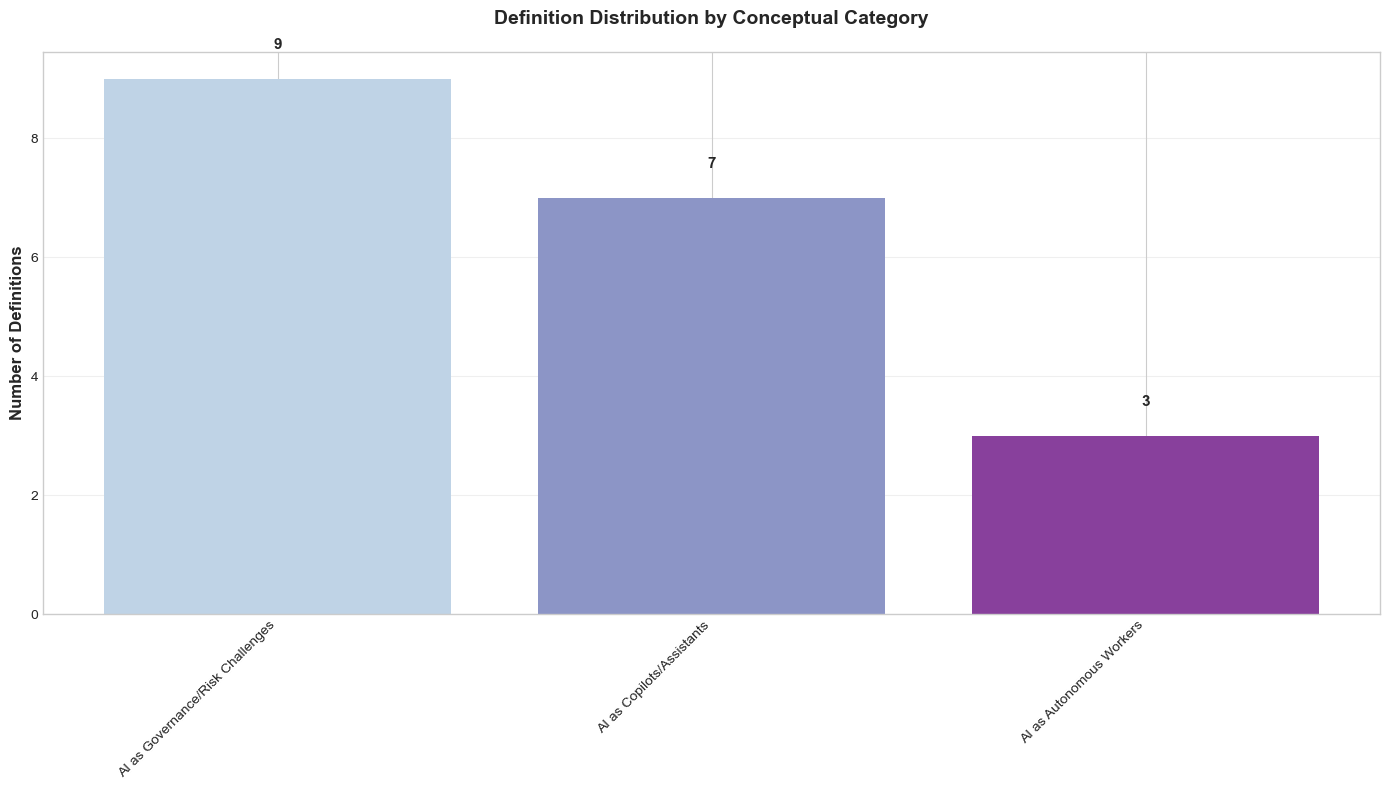

💾 Graph saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\taxonomy\taxonomy_distribution.png


In [35]:
# Count definitions per category
category_counts = df_definitions[category_col].value_counts()

# Create mapping to full labels
category_labels = {cat_id: TAXONOMY_CATEGORIES[cat_id]['label'] 
                  for cat_id in category_counts.index}
category_counts.index = category_counts.index.map(category_labels)

# Plotting
fig, ax = plt.subplots(figsize=(14, 8))

colors = sns.color_palette('BuPu', len(category_counts))
bars = ax.bar(range(len(category_counts)), category_counts.values, 
             color=colors, linewidth=1.5)

ax.set_xticks(range(len(category_counts)))
ax.set_xticklabels(category_counts.index, rotation=45, ha='right', fontsize=10)
ax.set_ylabel('Number of Definitions', fontsize=12, fontweight='bold')
ax.set_title('Definition Distribution by Conceptual Category', 
            fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3)

for i, (bar, count) in enumerate(zip(bars, category_counts.values)):
    ax.text(i, count + 0.5, str(count), ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(TAXONOMY_DIR / 'taxonomy_distribution.png', bbox_inches='tight')
plt.show()

print(f"💾 Graph saved to: {TAXONOMY_DIR / 'taxonomy_distribution.png'}")

### Distribution per source type

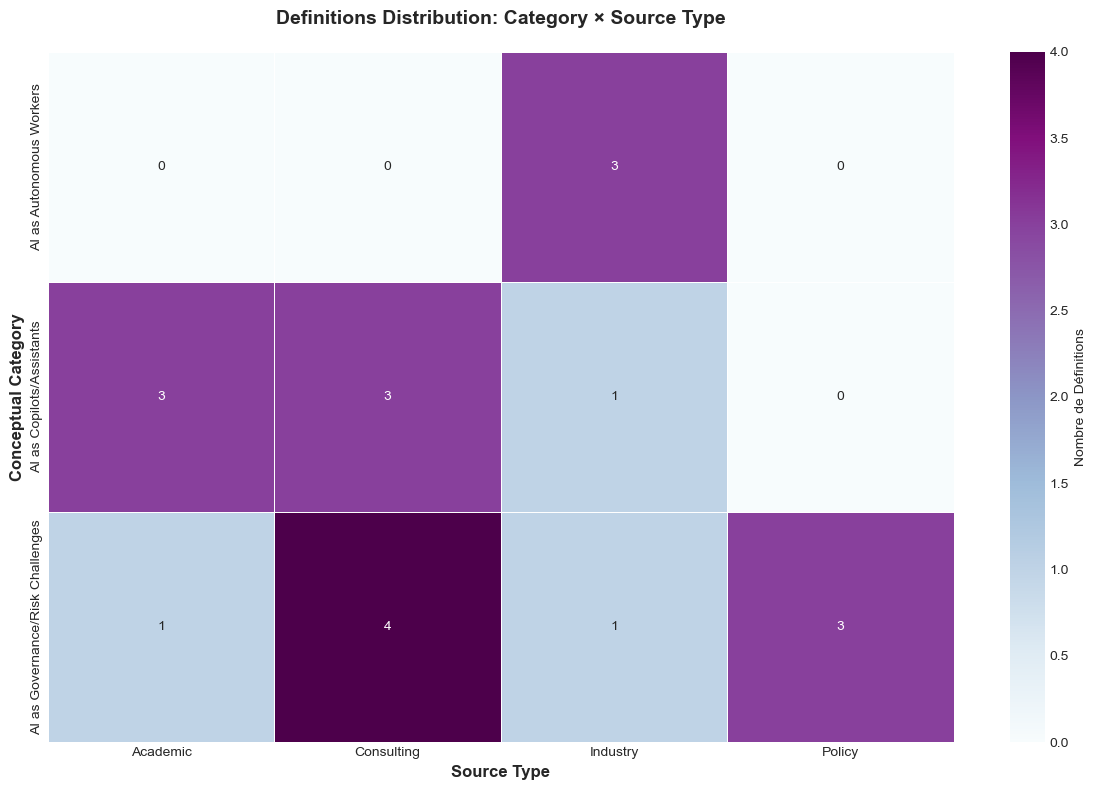

💾 Heatmap saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\taxonomy\taxonomy_by_source_heatmap.png


In [19]:
# Create matrix category × source type
cross_tab = pd.crosstab(
    df_definitions[category_col].map(lambda x: TAXONOMY_CATEGORIES[x]['label']),
    df_definitions['source_type']
)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(cross_tab, annot=True, fmt='d', cmap='BuPu', 
           linewidths=0.5, cbar_kws={'label': 'Nombre de Définitions'}, ax=ax)

ax.set_xlabel('Source Type', fontsize=12, fontweight='bold')
ax.set_ylabel('Conceptual Category', fontsize=12, fontweight='bold')
ax.set_title('Definitions Distribution: Category × Source Type', 
            fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig(TAXONOMY_DIR / 'taxonomy_by_source_heatmap.png', bbox_inches='tight')
plt.show()

print(f"💾 Heatmap saved to: {TAXONOMY_DIR / 'taxonomy_by_source_heatmap.png'}")

### Treemap

In [20]:
treemap_data = []

for cat_id, cat_info in TAXONOMY_CATEGORIES.items():
    count = (df_definitions[category_col] == cat_id).sum()
    if count > 0:
        treemap_data.append({
            'category': cat_info['label'],
            'count': count,
            'parent': 'Agentic AI Definitions'
        })
        
        # Ajouter les sous-niveaux par type de source
        for source_type in df_definitions['source_type'].unique():
            source_count = ((df_definitions[category_col] == cat_id) & 
                          (df_definitions['source_type'] == source_type)).sum()
            if source_count > 0:
                treemap_data.append({
                    'category': f"{source_type} ({source_count})",
                    'count': source_count,
                    'parent': cat_info['label']
                })

df_treemap = pd.DataFrame(treemap_data)

In [21]:
# Add root node
root_count = df_definitions.shape[0]
df_treemap = pd.concat([
    pd.DataFrame([{'category': 'Agentic AI Definitions', 'count': root_count, 'parent': ''}]),
    df_treemap
], ignore_index=True)

# Treemap using Plotly
fig = px.treemap(
    df_treemap,
    names='category',
    parents='parent',
    values='count',
    title='hierarchical Taxonomy of Agentic AI Definitions',
    color='count',
    color_continuous_scale='BuPu' ## RdYlBu_r
)

fig.update_layout(
    font=dict(size=14),
    title_font=dict(size=18, family='Arial Black'),
    height=700
)

fig.write_html(TAXONOMY_DIR / 'taxonomy_treemap.html')
fig.show()

print(f"💾 Treemap saved to: {TAXONOMY_DIR / 'taxonomy_treemap.html'}")

💾 Treemap saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\taxonomy\taxonomy_treemap.html


### Sunburst Chart

In [22]:
# Create sunburst chart
fig = px.sunburst(
    df_treemap,
    names='category',
    parents='parent',
    values='count',
    title='Definitions Taxonomy',
    color='count',
    color_continuous_scale='BuPu' ## Viridis
)

fig.update_layout(
    font=dict(size=13),
    title_font=dict(size=18, family='Arial Black'),
    height=700
)

fig.write_html(TAXONOMY_DIR / 'taxonomy_sunburst.html')
fig.show()

print(f"💾 Sunburst saved to: {TAXONOMY_DIR / 'taxonomy_sunburst.html'}")

💾 Sunburst saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\taxonomy\taxonomy_sunburst.html


### Sankey Graph (Flow: Source Type → Category)

In [23]:
source_types = df_definitions['source_type'].unique()
categories = df_definitions[category_col].unique()

# Mappings
source_to_idx = {s: i for i, s in enumerate(source_types)}
cat_to_idx = {c: i + len(source_types) for i, c in enumerate(categories)}

In [24]:
# Flows
sources = []
targets = []
values = []
labels = list(source_types) + [TAXONOMY_CATEGORIES[c]['label'] for c in categories]

for _, row in df_definitions.iterrows():
    source_idx = source_to_idx[row['source_type']]
    target_idx = cat_to_idx[row[category_col]]
    
    # Check if existing flow
    try:
        idx = sources.index(source_idx)
        if targets[idx] == target_idx:
            values[idx] += 1
            continue
    except ValueError:
        pass
    
    sources.append(source_idx)
    targets.append(target_idx)
    values.append(1)

In [37]:
colors = sns.color_palette('BuPu', len(labels))
# Create Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color=['slategrey', 'lightsteelblue', 'cornflowerblue', 'lightskyblue', 
               'lavender', 'mediumpurple', 'darkorchid', 'mediumorchid'][:len(labels)]
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values
    )
)])

fig.update_layout(
    title="Flux des Définitions: Type de Source → Catégorie Conceptuelle",
    font=dict(size=12),
    height=600
)

fig.write_html(TAXONOMY_DIR / 'taxonomy_sankey.html')
fig.show()

print(f"💾 Sankey sauvegardé: {TAXONOMY_DIR / 'taxonomy_sankey.html'}")

💾 Sankey sauvegardé: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\taxonomy\taxonomy_sankey.html


## 📊 Categories comparative analysis

In [26]:
# Stats per category
for cat_id, cat_info in TAXONOMY_CATEGORIES.items():
    cat_defs = df_definitions[df_definitions[category_col] == cat_id]
    
    if len(cat_defs) == 0:
        continue
    
    print(f"{cat_info['label']}")
    
    print(f"  Total count      : {len(cat_defs)}")
    print(f"  Type distribution:")
    
    for source_type in cat_defs['source_type'].value_counts().index:
        count = (cat_defs['source_type'] == source_type).sum()
        pct = count / len(cat_defs) * 100
        print(f"    • {source_type:15} : {count:2} ({pct:5.1f}%)")

AI as Copilots/Assistants
  Total count      : 7
  Type distribution:
    • Consulting      :  3 ( 42.9%)
    • Academic        :  3 ( 42.9%)
    • Industry        :  1 ( 14.3%)
AI as Autonomous Workers
  Total count      : 3
  Type distribution:
    • Industry        :  3 (100.0%)
AI as Governance/Risk Challenges
  Total count      : 9
  Type distribution:
    • Consulting      :  4 ( 44.4%)
    • Policy          :  3 ( 33.3%)
    • Academic        :  1 ( 11.1%)
    • Industry        :  1 ( 11.1%)


## 📋 Summary for report

In [27]:
summary_text = f"""
MINI-TAXONOMY OF AGENTIC AI DEFINITIONS
{'='*70}

METHODOLOGY
{'-'*70}
• Semi-automatic extraction: {len(df_candidates)} candidate definitions
• Manual validation: {len(df_definitions)} definitions
• Categorization: 4 main conceptual categories

RESULTS
{'-'*70}
"""

for cat_id, cat_info in TAXONOMY_CATEGORIES.items():
    if cat_id == 'other':
        continue
    
    count = (df_definitions[category_col] == cat_id).sum()
    pct = count / len(df_definitions) * 100 if len(df_definitions) > 0 else 0
    
    summary_text += f"\n{cat_info['label']}: {count} definitions ({pct:.1f}%)\n"
    summary_text += f"  {cat_info['description']}\n"

summary_text += f"\n{'-'*70}\n"
summary_text += "KEY INSIGHTS\n"
summary_text += f"{'-'*70}\n"

# Identify dominant category
dominant_cat = df_definitions[category_col].value_counts().idxmax()
dominant_count = df_definitions[category_col].value_counts().max()
dominant_pct = dominant_count / len(df_definitions) * 100

summary_text += f"\n• Dominant category: {TAXONOMY_CATEGORIES[dominant_cat]['label']} ({dominant_pct:.1f}%)\n"

# Analyze per source type
summary_text += "\n• Differences per source type:\n"
for source_type in df_definitions['source_type'].unique():
    source_defs = df_definitions[df_definitions['source_type'] == source_type]
    if len(source_defs) > 0:
        top_cat = source_defs[category_col].value_counts().idxmax()
        summary_text += f"  - {source_type}: favors '{TAXONOMY_CATEGORIES[top_cat]['label']}'\n"

print(summary_text)


MINI-TAXONOMY OF AGENTIC AI DEFINITIONS

METHODOLOGY
----------------------------------------------------------------------
• Semi-automatic extraction: 19 candidate definitions
• Manual validation: 19 definitions
• Categorization: 4 main conceptual categories

RESULTS
----------------------------------------------------------------------

AI as Copilots/Assistants: 7 definitions (36.8%)
  AI agents that augment human work, provide suggestions, collaborate with users

AI as Autonomous Workers: 3 definitions (15.8%)
  AI agents that independently execute tasks with minimal human intervention

AI as Multi-Agent Ecosystems/Orchestrators: 0 definitions (0.0%)
  AI systems coordinating multiple agents, workflows, or complex processes

AI as Governance/Risk Challenges: 9 definitions (47.4%)
  AI agents framed through ethical, regulatory, or risk management lens

----------------------------------------------------------------------
KEY INSIGHTS
----------------------------------------------

In [28]:
summary_file = TAXONOMY_DIR / 'taxonomy_summary.txt'
with open(summary_file, 'w', encoding='utf-8') as f:
    f.write(summary_text)

print(f"\n💾 Summary saved to: {summary_file}")


💾 Summary saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\taxonomy\taxonomy_summary.txt


## 💾 Save results

In [29]:
# Defs with categories
df_definitions.to_csv(TAXONOMY_DIR / 'definitions_categorized.csv', 
                     index=False, encoding='utf-8')
print(f"✅ Categorized definitions saved to: {TAXONOMY_DIR / 'definitions_categorized.csv'}")

✅ Categorized definitions saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\taxonomy\definitions_categorized.csv


In [30]:
# Table
report_table = []
for cat_id, cat_info in TAXONOMY_CATEGORIES.items():
    if cat_id == 'other':
        continue
    
    cat_defs = df_definitions[df_definitions[category_col] == cat_id]
    
    for _, row in cat_defs.iterrows():
        report_table.append({
            'Category': cat_info['label'],
            'Report': row['filename'],
            'Source_Type': row['source_type'],
            'Definition_Excerpt': row['text'][:200] + '...' if len(row['text']) > 200 else row['text']
        })

df_report_table = pd.DataFrame(report_table)
df_report_table.to_csv(TAXONOMY_DIR / 'taxonomy_table_for_report.csv', 
                       index=False, encoding='utf-8')
print(f"✅ Table saved to: {TAXONOMY_DIR / 'taxonomy_table_for_report.csv'}")

✅ Table saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\taxonomy\taxonomy_table_for_report.csv


In [31]:
# Aggregated stats
stats = {
    'total_definitions': len(df_definitions),
    'num_categories': len([c for c in TAXONOMY_CATEGORIES.keys() if c != 'other']),
    'category_distribution': {
        TAXONOMY_CATEGORIES[cat]['label']: int((df_definitions[category_col] == cat).sum())
        for cat in TAXONOMY_CATEGORIES.keys()
    },
    'by_source_type': {}
}

for source_type in df_definitions['source_type'].unique():
    source_defs = df_definitions[df_definitions['source_type'] == source_type]
    stats['by_source_type'][source_type] = {
        'total': len(source_defs),
        'distribution': {
            TAXONOMY_CATEGORIES[cat]['label']: int((source_defs[category_col] == cat).sum())
            for cat in TAXONOMY_CATEGORIES.keys()
        }
    }

with open(TAXONOMY_DIR / 'taxonomy_statistics.json', 'w') as f:
    json.dump(stats, f, indent=2)

print(f"✅ JSON stats saved to: {TAXONOMY_DIR / 'taxonomy_statistics.json'}")

✅ JSON stats saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\taxonomy\taxonomy_statistics.json


## 📝 Texte template for report

In [32]:
template = f"""
### Mini-Taxonomy of Definitions of "Agentic AI"

A hybrid qualitative-quantitative analysis was conducted to extract and 
categorize explicit definitions of "agentic AI" across the corpus. The 
methodology combined:

1. **Semi-automatic extraction**: Pattern matching identified {len(df_candidates)} 
   candidate definitions containing key terms ("agentic AI", "AI agents", 
   "autonomous agents") and definitional markers ("is defined as", "refers to").

2. **Manual validation**: Each candidate was manually reviewed, resulting in 
   {len(df_definitions)} validated definitions spanning {len(df_definitions['doc_id'].unique())} 
   reports.

3. **Conceptual categorization**: Definitions were grouped into four primary 
   conceptual frames:

"""

for cat_id in ['copilot', 'autonomous_worker', 'orchestrator', 'governance']:
    cat_info = TAXONOMY_CATEGORIES[cat_id]
    count = (df_definitions[category_col] == cat_id).sum()
    pct = count / len(df_definitions) * 100 if len(df_definitions) > 0 else 0
    
    template += f"\n**{cat_info['label']}** ({pct:.1f}%)\n"
    template += f"{cat_info['description']}\n"

template += f"""
#### Results and Interpretation

Figure X presents the distribution of definitions across conceptual categories. 
The dominant frame is **{TAXONOMY_CATEGORIES[dominant_cat]['label']}** ({dominant_pct:.1f}%), 
suggesting that the prevailing discourse conceptualizes agentic AI as 
{TAXONOMY_CATEGORIES[dominant_cat]['description'].lower()}.

**Institutional differences** (Figure Y - Heatmap) reveal:

"""

for source_type in df_definitions['source_type'].unique():
    source_defs = df_definitions[df_definitions['source_type'] == source_type]
    if len(source_defs) > 0:
        top_cat = source_defs[category_col].value_counts().idxmax()
        top_pct = (source_defs[category_col] == top_cat).sum() / len(source_defs) * 100
        template += f"- **{source_type}**: {top_pct:.0f}% frame agentic AI as '{TAXONOMY_CATEGORIES[top_cat]['label']}'\n"

template += f"""
**Key insight**: The taxonomy exposes conceptual fragmentation in how agentic 
AI is defined. While some actors emphasize augmentation (copilots), others 
stress full autonomy (autonomous workers) or systemic complexity (orchestrators). 
This definitional ambiguity poses challenges for standardization and may lead 
to misaligned adoption strategies across organizations.

**Table 1** (see Appendix) provides the complete taxonomy with representative 
definitions from each category and source type.
"""

print(template)

with open(TAXONOMY_DIR / 'report_template.txt', 'w', encoding='utf-8') as f:
    f.write(template)

print(f"\n💾 Template saved to: {TAXONOMY_DIR / 'report_template.txt'}")

KeyError: 'doc_id'

## 📋 Step 5 summary

**✅ Completed analysis:**
- Semi-automated extraction of definitions (pattern matching)
- Classification into 4 conceptual categories
- Manual validation (CSV file for revision)
- Comparative analysis by source type
- Multiple visualizations (bar, heatmap, treemap, sunburst, sankey)

**📂 Generated files:**
- 5 PNG/HTML vizualisations
- 3 CSV files (candidates, definitions, table report)
- 2 JSON files (statistics)
- 2 TXT files (summary, template)

**📊 Visuals for report:**
1. `taxonomy_distribution.png` - Global distribution
2. `taxonomy_by_source_heatmap.png` - Heatmap per source
3. `taxonomy_treemap.html` - Interactive hierarchical view
4. `taxonomy_table_for_report.csv` - Complete table

**🔑 Key insights:**
- Conceptual fragmentation of definitions
- Narrative differences between source types
- Dominance of a particular framework (to interpret)

In [ ]:
# Summary Step 5
print("STEP 5 FINISHED SUCCESSFULLY!")
print(f"\n📊 Mini-taxonomy of definitions summary:")
print(f"  • Extracted definitions    : {len(df_candidates)} candidates")
print(f"  • Validated definitions    : {len(df_definitions)}")
print(f"  • Conceptual categories    : 4 principales")
print(f"  • Documents                : {len(df_definitions['doc_id'].unique())}")
print(f"  • Sources types            : {len(df_definitions['source_type'].unique())}")
print(f"\n📂 All files saved to: {TAXONOMY_DIR}")
print(f"\n✅ Code part done!")

STEP 5 FINISHED SUCCESSFULLY!

📊 Mini-taxonomy of definitions summary:
  • Extracted definitions    : 750 candidates
  • Validated definitions    : 750
  • Conceptual categories    : 4 principales


KeyError: 'doc_id'